In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import seed
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [29]:
# Read the training data and making the use of read_csv parameters to set a particular column as an index and parsing the same to date time objects.
df = pd.read_csv('2BW00816_Eng Pri_Training Data.csv', parse_dates=True, index_col="SS_TimeStamp", usecols=[0,8,9,12])
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [3]:
# Read the testing data 
test_df = pd.read_csv('combined_testing_data.csv')

In [4]:
# df.drop(df[df['RT-LT_EXH_TEMP'] >20].index, inplace = True) 
# df.drop(df[df['RT-LT_EXH_TEMP'] <-20].index, inplace = True)

In [5]:
# Manilpulations done similar to that with training data 
Test_dataframe=pd.read_csv('combined_testing_data.csv', parse_dates=True, index_col="Observation Date (UTC-05:00)", usecols=[0,8,9,12])
Test_dataframe.sample(1)

,LT_EXH_TEMP (Lt Exh Temp(106)) Actual,RT_EXH_TEMP (Rt Exh Temp(108)) Actual,TURBO_INLET_PRESSURE (Trbo In Pres(101)) Actual
Observation Date (UTC-05:00),,,
2018-09-16 20:23:31,561,557,96.0


In [6]:
# Shape of both the datasets
df.shape,Test_dataframe.shape

((2928, 3), (96481, 3))

In [7]:
# normalize both the datasets
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_parameters=scaler.fit(df)
X_train = scaled_parameters.transform(df)
X_test = scaled_parameters.transform(Test_dataframe)

In [9]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (2928, 1, 3)
Test data shape: (96481, 1, 3)


In [10]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='linear', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = Dropout(0.2)(L1)
    L3 = LSTM(4, activation='sigmoid', return_sequences=False)(L1)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='sigmoid', return_sequences=True)(L4)
    L6 = Dropout(0.2)(L5)
    L7 = LSTM(16, activation='linear', return_sequences=True)(L5)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [11]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 3)              51    

In [12]:
# fit the model to the data
nb_epochs = 10
batch_size = 14
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/10
199/199 [==============================] - 6s 8ms/step - loss: 0.1731 - accuracy: 0.1381 - val_loss: 0.1123 - val_accuracy: 0.7007
Epoch 2/10
199/199 [==============================] - 1s 3ms/step - loss: 0.1210 - accuracy: 0.6761 - val_loss: 0.0819 - val_accuracy: 0.7007
Epoch 3/10
199/199 [==============================] - 1s 3ms/step - loss: 0.0841 - accuracy: 0.6700 - val_loss: 0.0370 - val_accuracy: 0.9116
Epoch 4/10
199/199 [==============================] - 1s 3ms/step - loss: 0.0470 - accuracy: 0.8595 - val_loss: 0.0254 - val_accuracy: 0.9048
Epoch 5/10
199/199 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.8534 - val_loss: 0.0219 - val_accuracy: 0.9184
Epoch 6/10
199/199 [==============================] - 1s 3ms/step - loss: 0.0295 - accuracy: 0.8498 - val_loss: 0.0196 - val_accuracy: 0.9184
Epoch 7/10
199/199 [==============================] - 1s 3ms/step - loss: 0.0275 - accuracy: 0.8516 - val_loss: 0.0183 - val_accuracy: 0.9388
Epoch 

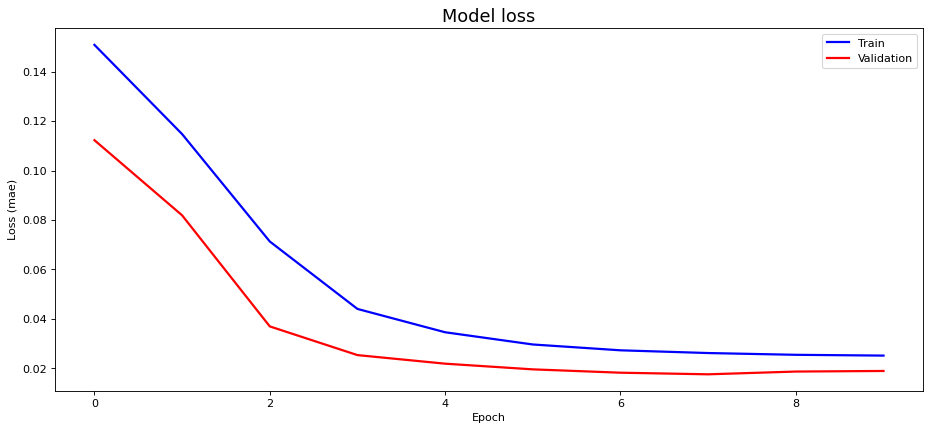

In [13]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


In [15]:
# Predictions using the model on the testing data and reshape the predictions so that inverse_transform could be performed on it
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [18]:
# Inverse_transform on the predicted values and the actual values
X_pred1 = scaler.inverse_transform(X_pred)
X_test = scaler.inverse_transform(X_test)

In [23]:
X_test.shape, X_pred1.shape

((96481, 3), (96481, 3))

In [19]:
# Residual i.e (Actual values - Predicted values)
resid=X_test[:]-X_pred1 [:]

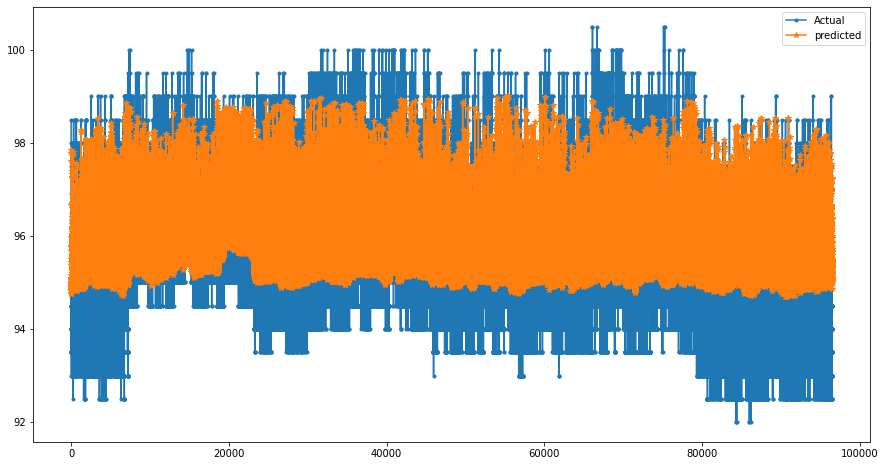

In [20]:
# Visualisation through line graph on one of the feature of data
# Actual values are in blue and Predicted values are in orange
plt.figure(figsize=[15,8])
plt.plot(X_test[:,2],label="Actual",marker=".")
plt.plot(X_pred1[:,2],label="predicted",marker="*")
plt.legend(loc="best")
plt.show()

# It can be clearly seen that the values are bounded with respect to the training data and thus resulting in accurate predictions.

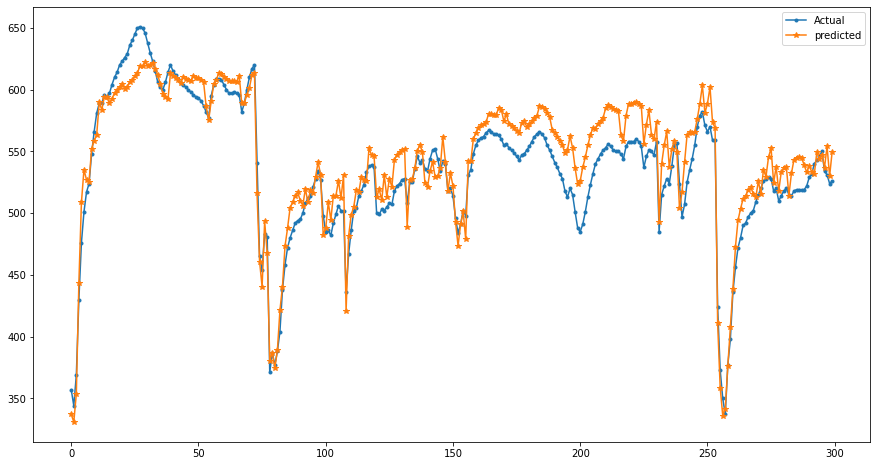

In [21]:
# A part of the whole data set for proper understanding
plt.figure(figsize=[15,8])
plt.plot(X_test[:300,0],label="Actual",marker=".")
plt.plot(X_pred1[:300,0],label="predicted",marker="*")
plt.legend(loc="best")
plt.show()